# 1. Introduction

In this notebook we are going to deal with a supervised learning(learning with a teacher) problem called **Classification**.

## 1.1. Classification

It is one type of supervised learning method where the target variable is categorical. The problem can be of binary class classification i.e. whether an email is spam or not, loan will be default or not etc. or it can be multiclass classification, predicting the type of fruit on the shape, size and colour.

There a numerous techniques to solve such task. In this notebook we are going to work on a SMS spam classifier using **Naive Bayes**.

### 1.1.1 Naive Bayes
The algorithm is inspired from Bayes Theorem. For an event B find the validity of the event A. It is called Naive because the assumptions can be right or wrong.
```
P(A|B) = P(B|A).P(A) / P(B)
```

# 2. Steps Involved:
    0. Importing the required libraries - for importing all the dependencies
    1. Making functions of the required steps.
    2. Importing dataset
    3. Exploratory Data Analysis (EDA) - for checking the nature and structure of the dataset
    4. Feature Engineering - for getting features from the dataset
    5. Model Building - for building the model (using sklearn)
    6. Model Training - fitting the model for classification
    7. Model Testing
    8. Model Evaluation
    9. Saving the model - for re-use.
    10.Loading the model - for loading the trained model
    11.Inference - for checking the utility of the model.
    12.Optimization - tuning the hyperparameters of model.
    
# 3. Prerequisites

## 3.1 Dataset 
sms_spam.csv has been used as dataset which consist of 2 columns:
    1. type
    2. text
    
## 3.2 Libraries Requirements 
``` 
    numpy == 1.16.3
    pandas == 0.24.2
    matplotlib == 3.0.3
    nltk == 3.4.1
    wordcloud == 1.5.0
    scikit_learn == 0.21.2
```
    
# 4. Use Case
Some famous use cases of Naive Bayes are :
    1. Document classification
    2. Weather prediction

## Step 0. Importing the required libraries

In [1]:
import numpy as np
import pandas as pd

# Data visualization
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Preprocessing and Training
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pickle

# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix

# Optimization
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Step 1. Making functions of the required steps

In [2]:
# FUNCTION FOR IMPORTING THE DATASET
# Input: path of the dataset (CSV)
# Output: dataframe 

def import_dataset(path):
    df = pd.read_csv(path)
    return df

In [3]:
# FUNCTION FOR CHECKING DUPLiCATE ROWS
# Input : dataframe
# Output: no. of duplicate rows

def num_duplicate(df):
    return len(df[df.duplicated() == True])

In [4]:
# FUNCTION FOR CLEARING THE SMS TEXT
# Input: dataframe and column name
# Output: string converted to lower case and has trimmed left and right spaces

def clean_text(df, col_name):
    df[col_name] = df[col_name].str.lower()
    df[col_name] = df[col_name].str.strip()
    
    return df

In [5]:
# FUNCTION FOR PLOTTING CATEGORIES
# Input: dataframe and column name
# Output: bar graph that shows the distribution of values of each category.

def plt_category(df, col_name):
    font_style = {'size':14, 'weight':'bold', 'color':'#000000'}
    df[col_name].value_counts().plot(kind='bar', color=['#005f00', '#8f0000'], 
                                     alpha=0.8)
    plt.xlabel('SMS Category', fontdict=font_style)
    plt.ylabel('Count', fontdict=font_style)
    plt.show()

In [6]:
# FUNCTION FOR PLOTTING WORDCLOUD
# Input: dataframe, column name and stopwords
# Output: wordcloud of spam and ham

def word_cloud(df, col_name, stop_words):
    def generate_cloud(value, title):
        type_df = df[df[col_name] == value]
        wordcloud = WordCloud(background_color='#000000', stopwords=stop_words,
                              max_words=50, max_font_size=50, random_state=5
                             ).generate(str(type_df['text']))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontdict={'size':18})
        plt.axis('off')
        
    plt.subplot(2, 1, 1)
    generate_cloud(value='spam', title='Spam')
    
    plt.subplot(2, 1, 2)
    generate_cloud(value='ham', title='Not Spam')
    plt.show()

In [7]:
# FUNCTION FOR GETTING FEATURE AND LABEL
# Input: dataframe
# Output: numpy array of feature and label

def get_features(df):
    X = df.text.values
    y = df.type.values
    
    return X, y

In [8]:
# FUNCTION FOR SAVING THE MODEL
# Input: model object, file name
# Output: pickle file of the model

def save_pickle(model_object, file_name):
    file_pkl = open(file_name, 'wb')
    pickle.dump(model_object, file_pkl)
    file_pkl.close()

In [9]:
# FUNCTION FOR REMOVING UNNECESSARY WORDS AND PUNCTUATIONS FROM SMS
# Input: SMS
# Output: A cleaned SMS with no punctuations

def clean_str(message: str):
    message = re.sub(r"\'s", "", message)
    message = re.sub(r"\'ve", "", message)
    message = re.sub(r"n\'t", "", message)
    message = re.sub(r"\'re", "", message)
    message = re.sub(r"\'d", "", message)
    message = re.sub(r"\'ll", "", message)
    message = re.sub(r",", "", message)
    message = re.sub(r"!", " ! ", message)
    message = re.sub(r"\(", "", message)
    message = re.sub(r"\)", "", message)
    message = re.sub(r"\?", "", message)
    message = re.sub(r"'", "", message)
    message = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", message)
    message = re.sub(r"[0-9]\w+|[0-9]","", message)
    message = re.sub(r"\s{2,}", " ", message)

    return message.strip().lower()

In [10]:
# FUNCTION FOR TRANSFORMING SENTENCES TO TF-IDF VECTORS
# Input: a numpy array of features and pickle file name
# Output: transformed vectors and saved model of vectorizer

def gen_tf_idf_vectors(X, lemmatizer):
    for index, value in enumerate(X):
        X[index] = ' '.join([lemmatizer.lemmatize(word) for word in clean_str(value).split()])

    # Vectorizing the text
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, ngram_range=(1, 3),
                                 sublinear_tf=True, use_idf=True)
    X = vectorizer.fit_transform(X)
    # Saving the learned vectors
    save_pickle(vectorizer, 'scaling_models/tfidf_vectorizer.pkl')
    
    return X

In [11]:
# FUNCTION FOR SPLITTING DATASET INTO TRAIN AND TEST
# Input: Input features and label
# Output: Splitted dataset into train and test

def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                       random_state=5, stratify=y)
    return X_train, X_test, y_train, y_test

In [12]:
# FUNCTION FOR MODEL BUILDING
# Input: null
# Output: model

def build_model():
    naive_bayes = MultinomialNB(alpha=1.0, fit_prior=True,
                                class_prior=None)
    return naive_bayes

In [13]:
# FUNCTION FOR MODEL TRAINING
# Input: model object, training set
# Output: trained model

def train_model(naive_bayes, X_train, y_train):
    naive_bayes.fit(X_train.toarray(), y_train)

In [14]:
# FUNCTION FOR MODEL TESTING
# Input: model object and test feature
# Output: predicted values

def test_model(naive_bayes, X_test):
    y_pred = naive_bayes.predict(X_test)
    
    return y_pred

In [15]:
# FUNCTION FOR MODEL EVALUATION
# Input: True values and predicted values
# Output: Accuracy score and confusion matrix

def eval_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print("Accuracy= {:.2f}%".format(100 * accuracy))
    print("Confusion Matrix:", cm, sep='\n')

In [16]:
# FUNCTION FOR LOADING THE SAVED MODELS
# Input: pickle file name
# Output: model object

def load_model(pkl_name):
    pkl = open(pkl_name, 'rb')
    model_object = pickle.load(pkl)
    pkl.close()
    
    return model_object

In [17]:
# FUNCTION FOR OPTIMISING THE MODEL USING K_FOLD CROSS VALIDATION
# Input: number of splits, model object, feature and label
# Output: accuracy score after cross validation

def cross_validation(num_splits, naive_bayes, feature, label):
    kfold = KFold(n_splits=num_splits, random_state=5)
    result = cross_val_score(naive_bayes, feature, label, cv=kfold, scoring='accuracy')
    
    print("Accuracy achieved= {:.2f}%".format(result.mean()*100))

In [18]:
# FUNCTION FOR OPTIMISING THE MODEL USING GRID SEARCH CROSS VALIDATION
# Input: model object, parameter dictionary, number of splits, feature and label
# Output: accuracy score

def grid_search(naive_bayes, params, num_splits, feature, label):
    grid = GridSearchCV(estimator=naive_bayes,
                        param_grid=params,
                        cv=num_splits)
    grid_result = grid.fit(feature, label)
    
    print("Best accuracy achieved= {:.2f}% using {}".format(grid_result.best_score_ * 100, 
                                                            grid_result.best_params_))

## Step 2. Importing dataset

In [19]:
# Importing CSV
path = 'data/sms_spam.csv'
spam_df = import_dataset(path)

## Step 3. Exploratory Data Analysis

In [20]:
# Checking the structure of data
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
type    5559 non-null object
text    5559 non-null object
dtypes: object(2)
memory usage: 86.9+ KB


In [21]:
# Checking the shape of data
# First entry represent the number of rows and second represents columns
spam_df.shape

(5559, 2)

In [22]:
# Checking the dataset
spam_df.head()

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [23]:
# Checking number of duplicate rows
num_duplicate(spam_df)

403

In [24]:
# Dropping duplicate rows
spam_df = spam_df.drop_duplicates()

In [25]:
# Converting the sms text to lower case and trimming left and right space
spam_df = clean_text(spam_df, col_name="text")

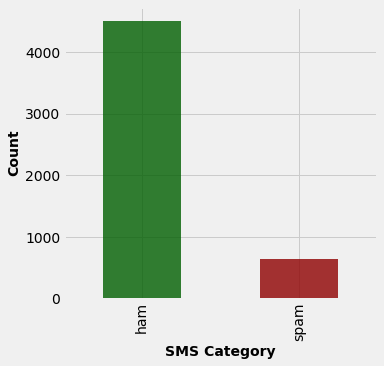

In [26]:
# Plotting the messages of each category

# Plot style
plt.style.use('fivethirtyeight')
# Plot size
plt.rcParams['figure.figsize'] = [5, 5]

plt_category(spam_df, col_name="type")

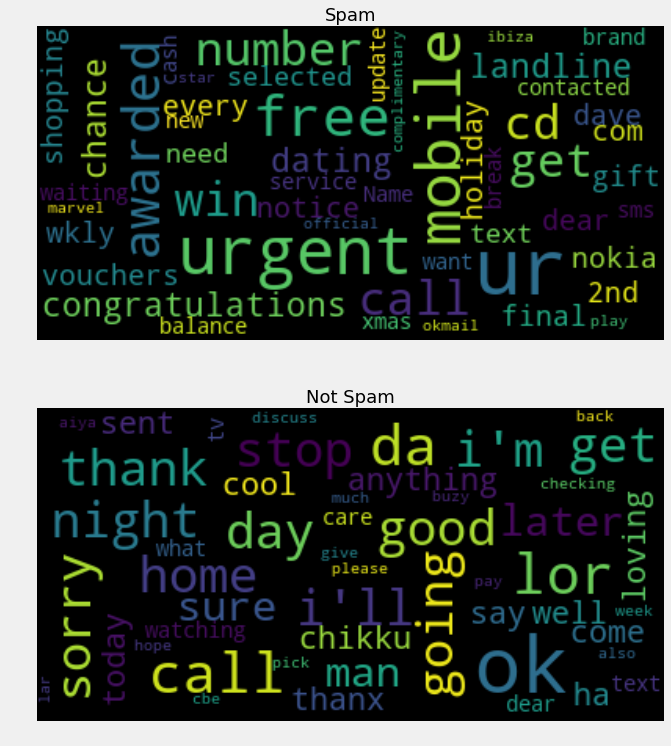

In [27]:
# Plotting the words found in each category

# Plot size
plt.rcParams['figure.figsize'] = [10, 12]

word_cloud(spam_df, col_name='type', stop_words=set(stopwords.words('english')))

## Step 4. Feature Engineering

In [28]:
# Getting feature and label
X, y = get_features(spam_df)

In [29]:
# Tranforming the messages into vectors
lemmatizer = WordNetLemmatizer()
X = gen_tf_idf_vectors(X, lemmatizer)

In [30]:
# Splitting dataset into train and test set
X_train, X_test, y_train, y_test = split_data(X, y)

## Step 5. Model Building

In [31]:
# Building the model
naive_bayes = build_model()

## Step 6. Model Training

In [32]:
# Training the model
train_model(naive_bayes, X_train, y_train)

## Step 7. Model Testing

In [33]:
# Testing the model
y_pred = test_model(naive_bayes, X_test)

## Step 8. Model Evaluation

In [34]:
# Performance of the model
eval_model(y_test, y_pred)

Accuracy= 97.67%
Confusion Matrix:
[[901   0]
 [ 24 107]]


## Step 9. Saving the model

In [35]:
# Saving the trained model
save_pickle(naive_bayes, 'models/spam_classifier.pkl')

## Step 10. Loading the model

In [36]:
# Loading the scaler and trained model
tf_idf = load_model('scaling_models/tfidf_vectorizer.pkl')
naive_bayes = load_model('models/spam_classifier.pkl')

## Step 11. Inference

In [37]:
 # Loading the test CSV
path = 'data/sms_spam_test.csv'
spam_test = import_dataset(path)

In [38]:
 # Checking the dataset
spam_test.head()

,type,text
0,ham,Hey!!! I almost forgot ... Happy B-day babe ! ...
1,ham,Ok i go change also...
2,ham,Aiyar u so poor thing... I give u my support k...
3,ham,Mark works tomorrow. He gets out at 5. His wor...
4,ham,Hey next sun 1030 there's a basic yoga course....


In [39]:
 # Checking the shape of the data
# First entry represent the number of rows and second represents the number of columns
spam_test.shape

(126, 2)

In [40]:
# Converting the sms text to lower case and trimming left and right space
spam_test = clean_text(spam_test, col_name="text")

In [41]:
# Getting features and labels
spam_text_X, spam_test_y = get_features(spam_test)

In [42]:
# Transforming features
spam_text_X = tf_idf.transform(spam_text_X)

In [43]:
# Predicting the labels
spam_test_y_pred = naive_bayes.predict(spam_text_X)

In [44]:
# Evaluating the performance
eval_model(spam_test_y, spam_test_y_pred)

Accuracy= 99.21%
Confusion Matrix:
[[114   0]
 [  1  11]]


## Step 12. Optimization

In [45]:
# Performing cross validation
cross_validation(num_splits=5, naive_bayes=naive_bayes,
                 feature=X, label=y)

Accuracy achieved= 97.40%


In [46]:
# Performing grid search cross validation
params = {"alpha": [0.5, 0.6, 0.7, 0.8, 0.9],
         "fit_prior": [False, True]}
grid_search(naive_bayes, params, num_splits=5,
           feature=X, label=y)

Best accuracy achieved= 98.02% using {'alpha': 0.5, 'fit_prior': True}
